<a href="https://colab.research.google.com/github/baharbhz76/MastersThesis_WeedDetection_RGB-NIR/blob/main/G%2BNIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import os

# Define paths to the directories
rgb_dir = '/content/drive/MyDrive/train images'
nir_dir = '/content/drive/MyDrive/train NIR'
rgb_annotations_dir = '/content/drive/MyDrive/train annotations'
output_dir = '/content/drive/MyDrive/combined_GNIR'
output_annotations_dir = '/content/drive/MyDrive/combined_annotations'
def apply_bilateral_filter(image, d=9, sigmaColor=75, sigmaSpace=75):
  return cv2.bilateralFilter(image, d, sigmaColor, sigmaSpace)
  """
    Apply Gaussian bilateral filter to preserve edges.
    """

# Ensure output directories exist
os.makedirs(output_dir, exist_ok=True)
os.makedirs(output_annotations_dir, exist_ok=True)

def combine_channels(green_channel, nir_channel):
    # Create a dummy channel to make the image a 3-channel image
    dummy_channel = np.zeros_like(green_channel)
    # Stack the channels to form a 3-channel image
    combined_image = np.stack((green_channel, nir_channel, dummy_channel), axis=-1)
    return combined_image

def get_matching_files(rgb_dir, nir_dir, annotations_dir):
    rgb_files = {file: os.path.join(rgb_dir, file) for file in os.listdir(rgb_dir)}
    nir_files = {file: os.path.join(nir_dir, file) for file in os.listdir(nir_dir)}
    annotations_files = {file: os.path.join(annotations_dir, file) for file in os.listdir(annotations_dir)}

    common_files = set(rgb_files).intersection(set(nir_files)).intersection(set(annotations_files))
    return [rgb_files[file] for file in common_files], [nir_files[file] for file in common_files], [annotations_files[file] for file in common_files]

matched_rgb_files, matched_nir_files, matched_annotations_files = get_matching_files(rgb_dir, nir_dir, rgb_annotations_dir)
print("Matched files count:", len(matched_rgb_files))

for rgb_path, nir_path, annotation_path in zip(matched_rgb_files, matched_nir_files, matched_annotations_files):
    file_name = os.path.basename(rgb_path)
    combined_image_path = os.path.join(output_dir, f"combined_{file_name}")

    rgb_img = cv2.imread(rgb_path, cv2.IMREAD_COLOR)
    nir_img = cv2.imread(nir_path, cv2.IMREAD_GRAYSCALE)
    if nir_img is not None:
      nir_img = apply_bilateral_filter(nir_img, d=9, sigmaColor=75, sigmaSpace=75)

    if rgb_img is None or nir_img is None:
        print(f"Failed to load images for {file_name}, skipping...")
        continue

    green_channel = rgb_img[:, :, 1]  # Extract the Green channel
    combined_img = combine_channels(green_channel, nir_img)

    cv2.imwrite(combined_image_path, combined_img)

    annotation_img = cv2.imread(annotation_path, cv2.IMREAD_UNCHANGED)
    if annotation_img is None:
        print(f"Failed to load annotation for {file_name}, skipping...")
        continue

    cv2.imwrite(combined_image_path, combined_img)

    print(f"Processed and saved data for {file_name}")


Matched files count: 318
Processed and saved data for jesi_05_12__4_8min_rid_frame284.png
Processed and saved data for jesi_05_12__8_12min_rid_frame20.png
Processed and saved data for jesi_05_12__8_12min_rid_frame52.png
Processed and saved data for jesi_05_12__0_4min_rid_frame143.png
Processed and saved data for jesi_05_12__8_12min_rid_frame92.png
Processed and saved data for jesi_05_12__0_4min_rid_frame142.png
Processed and saved data for jesi_05_18__4_8min_rid_frame142.png
Processed and saved data for jesi_05_12__4_8min_rid_frame216.png
Processed and saved data for jesi_05_12__8_12min_rid_frame63.png
Processed and saved data for jesi_05_18__4_8min_rid_frame153.png
Processed and saved data for jesi_05_18__8_12min_rid_frame221.png
Processed and saved data for jesi_05_12__8_12min_rid_frame150.png
Processed and saved data for jesi_05_12__0_4min_rid_frame169.png
Processed and saved data for jesi_05_12__0_4min_rid_frame97.png
Processed and saved data for jesi_05_18__4_8min_rid_frame37.png


In [ ]:
print("Number of RGB files:", len(os.listdir(rgb_dir)))
print("Number of NIR files:", len(os.listdir(nir_dir)))
print("Number of annotation files:", len(os.listdir(rgb_annotations_dir)))

Number of RGB files: 318
Number of NIR files: 318
Number of annotation files: 318


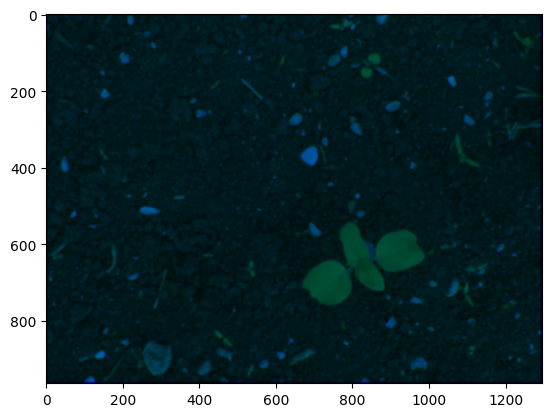

In [ ]:
#  # Load and display the combined image
import matplotlib.pyplot as plt
loaded_img = cv2.imread(combined_image_path)
loaded_img = cv2.cvtColor(loaded_img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for visualization
plt.imshow(loaded_img)
plt.show()

In [ ]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CombinedDataset(Dataset):
    def __init__(self, combined_image_dir, annotation_dir):
        self.combined_image_dir = combined_image_dir
        self.annotation_dir = annotation_dir
        self.image_mask_pairs = self._find_matching_files()

        # Normalization for the G, NIR, and a dummy channel
        self.transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.456, 0.45, 0.0], std=[0.224, 0.225, 1.0])  # Dummy channel has no variance
        ])

    def __len__(self):
        return len(self.image_mask_pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.image_mask_pairs[idx]
        rgb_img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        nir_img = cv2.imread(img_path.replace("RGB", "NIR"), cv2.IMREAD_GRAYSCALE)

        if rgb_img is None or nir_img is None:
            raise FileNotFoundError(f"One of the images was not found for {img_path} or {img_path.replace('RGB', 'NIR')}.")

        green_channel = rgb_img[:, :, 1]  # G channel from RGB
        dummy_channel = np.zeros_like(green_channel)  # Dummy channel for compatibility
        combined_img = self.combine_channels(green_channel, nir_img, dummy_channel)

        mask_rgb = cv2.imread(mask_path, cv2.IMREAD_COLOR)
        mask = self.convert_rgb_to_labels(mask_rgb)

        img_tensor = self.transforms(combined_img)
        mask_tensor = torch.from_numpy(mask).long()

        return img_tensor, mask_tensor

    def combine_channels(self, green_channel, nir_channel, dummy_channel):
        return np.stack((green_channel, nir_channel, dummy_channel), axis=-1)

    def _find_matching_files(self):
        image_mask_pairs = []
        image_files = os.listdir(self.combined_image_dir)
        for img_file in image_files:
            mask_filename = img_file.replace("combined_", "")
            img_path = os.path.join(self.combined_image_dir, img_file)
            mask_path = os.path.join(self.annotation_dir, mask_filename)
            if os.path.exists(mask_path):
                image_mask_pairs.append((img_path, mask_path))
        return image_mask_pairs

    def convert_rgb_to_labels(self, mask_rgb):
        mask = np.zeros((mask_rgb.shape[0], mask_rgb.shape[1]), dtype=np.uint8)
        mask[np.all(mask_rgb == [0, 0, 0], axis=-1)] = 0  # Soil
        mask[np.all(mask_rgb == [0, 255, 0], axis=-1)] = 1  # Crop
        mask[np.all(mask_rgb == [0, 0, 255], axis=-1)] = 2  # Weeds
        return mask

# Example usage
combined_image_dir = '/content/drive/MyDrive/combined_GNIR'
annotation_dir = '/content/drive/MyDrive/combined_annotations'
dataset = CombinedDataset(combined_image_dir, annotation_dir)
loader = DataLoader(dataset, batch_size=2, shuffle=True)

for images, masks in loader:
   print("Batch images shape:", images.shape)
   print("Batch masks shape:", masks.shape)







Batch images shape: torch.Size([2, 3, 964, 1296])
Batch masks shape: torch.Size([2, 964, 1296])
Batch images shape: torch.Size([2, 3, 964, 1296])
Batch masks shape: torch.Size([2, 964, 1296])
Batch images shape: torch.Size([2, 3, 964, 1296])
Batch masks shape: torch.Size([2, 964, 1296])
Batch images shape: torch.Size([2, 3, 964, 1296])
Batch masks shape: torch.Size([2, 964, 1296])
Batch images shape: torch.Size([2, 3, 964, 1296])
Batch masks shape: torch.Size([2, 964, 1296])
Batch images shape: torch.Size([2, 3, 964, 1296])
Batch masks shape: torch.Size([2, 964, 1296])
Batch images shape: torch.Size([2, 3, 964, 1296])
Batch masks shape: torch.Size([2, 964, 1296])
Batch images shape: torch.Size([2, 3, 964, 1296])
Batch masks shape: torch.Size([2, 964, 1296])
Batch images shape: torch.Size([2, 3, 964, 1296])
Batch masks shape: torch.Size([2, 964, 1296])
Batch images shape: torch.Size([2, 3, 964, 1296])
Batch masks shape: torch.Size([2, 964, 1296])
Batch images shape: torch.Size([2, 3, 96

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

def crop(encoder_layer, decoder_layer):
    if encoder_layer.size()[2] != decoder_layer.size()[2] or encoder_layer.size()[3] != decoder_layer.size()[3]:
        encoder_layer = F.interpolate(encoder_layer, size=(decoder_layer.size()[2], decoder_layer.size()[3]), mode='bilinear', align_corners=True)
    return encoder_layer

class ResNetUNet(nn.Module):
    def __init__(self, n_classes, n_channels=3, pretrained=True):  # Changed n_channels to 3
        super(ResNetUNet, self).__init__()
        self.resnet = models.resnet50(pretrained=pretrained)
        self.resnet.conv1 = nn.Conv2d(n_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Changed n_channels to 3
        self.encoder1 = self.resnet.layer1
        self.encoder2 = self.resnet.layer2
        self.encoder3 = self.resnet.layer3
        self.encoder4 = self.resnet.layer4
        self.decoder4 = nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2)
        self.decoder3 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder1 = nn.ConvTranspose2d(256, 64, kernel_size=2, stride=2)
        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.resnet.conv1(x)
        x1 = self.resnet.bn1(x1)
        x1 = self.resnet.relu(x1)
        x1 = self.resnet.maxpool(x1)
        e1 = self.encoder1(x1)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)
        d4 = self.decoder4(e4) + crop(e3, self.decoder4(e4))
        d3 = self.decoder3(d4) + crop(e2, self.decoder3(d4))
        d2 = self.decoder2(d3) + crop(e1, self.decoder2(d3))
        d1 = self.decoder1(d2)
        out = self.final_conv(d1)
        out = F.interpolate(out, size=(964, 1296), mode='bilinear', align_corners=True)  # Resize to match input
        return out



In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class DoubleConv(nn.Module):
#     """(convolution => [BN] => ReLU) * 2"""
#     def __init__(self, in_channels, out_channels, mid_channels=None):
#         super().__init__()
#         if not mid_channels:
#             mid_channels = out_channels
#         self.double_conv = nn.Sequential(
#             nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
#             nn.BatchNorm2d(mid_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True)
#         )

#     def forward(self, x):
#         return self.double_conv(x)

# class Down(nn.Module):
#     """Downscaling with maxpool then double conv"""
#     def __init__(self, in_channels, out_channels):
#         super().__init__()
#         self.maxpool_conv = nn.Sequential(
#             nn.MaxPool2d(2),
#             DoubleConv(in_channels, out_channels)
#         )

#     def forward(self, x):
#         return self.maxpool_conv(x)

# class Up(nn.Module):
#     """Upscaling then double conv"""
#     def __init__(self, in_channels, out_channels, bilinear=True):
#         super().__init__()
#         # if bilinear, use the normal convolutions to reduce the number of channels
#         if bilinear:
#             self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
#             self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
#         else:
#             self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
#             self.conv = DoubleConv(in_channels, out_channels)

#     def forward(self, x1, x2):
#         x1 = self.up(x1)
#         # input is CHW
#         diffY = x2.size()[2] - x1.size()[2]
#         diffX = x2.size()[3] - x1.size()[3]

#         x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
#                         diffY // 2, diffY - diffY // 2])
#         # if you have padding issues, see
#         # https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py
#         x = torch.cat([x2, x1], dim=1)
#         return self.conv(x)

# class OutConv(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(OutConv, self).__init__()
#         self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

#     def forward(self, x):
#         return self.conv(x)

# class UNet(nn.Module):
#     def __init__(self, n_channels, n_classes, bilinear=True):
#         super(UNet, self).__init__()
#         self.n_channels = n_channels
#         self.n_classes = n_classes
#         self.bilinear = bilinear

#         self.inc = DoubleConv(n_channels, 64)
#         self.down1 = Down(64, 128)
#         self.down2 = Down(128, 256)
#         self.down3 = Down(256, 512)
#         factor = 2 if bilinear else 1
#         self.down4 = Down(512, 1024 // factor)
#         self.up1 = Up(1024, 512 // factor, bilinear)
#         self.up2 = Up(512, 256 // factor, bilinear)
#         self.up3 = Up(256, 128 // factor, bilinear)
#         self.up4 = Up(128, 64, bilinear)
#         self.outc = OutConv(64, n_classes)

#     def forward(self, x):
#         x1 = self.inc(x)
#         x2 = self.down1(x1)
#         x3 = self.down2(x2)
#         x4 = self.down3(x3)
#         x5 = self.down4(x4)
#         x = self.up1(x5, x4)
#         x = self.up2(x, x3)
#         x = self.up3(x, x2)
#         x = self.up4(x, x1)
#         logits = self.outc(x)
#         return logits


In [ ]:
import torch.nn as nn
class CombinedLoss(nn.Module):
    def __init__(self):
        super(CombinedLoss, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()
        self.dice_loss = DiceLoss()

    def forward(self, inputs, targets):
        ce_loss = self.cross_entropy(inputs, targets)
        dl_loss = self.dice_loss(inputs, targets)
        return ce_loss + dl_loss

class DiceLoss(nn.Module):
    def forward(self, inputs, targets, smooth=1):
        inputs = F.softmax(inputs, dim=1)
        targets = F.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2).float()

        intersection = (inputs * targets).sum(dim=(2,3))
        dice = (2.*intersection + smooth) / (inputs.sum(dim=(2,3)) + targets.sum(dim=(2,3)) + smooth)

        return 1 - dice.mean()

In [ ]:
def iou_per_class(outputs, labels, n_classes):
    # Convert outputs to class predictions
    _, predictions = torch.max(outputs, 1)
    ious = []
    for cls in range(n_classes):
        prediction = (predictions == cls)
        truth = (labels == cls)
        intersection = torch.logical_and(prediction, truth).sum().item()
        union = torch.logical_or(prediction, truth).sum().item()
        if union == 0:
            iou = float('nan')  # or some other placeholder for no prediction
        else:
            iou = intersection / union
        ious.append(iou)
    return ious

In [ ]:
from torch.utils.data.dataset import random_split
torch.manual_seed(0)

# Assuming the total dataset size and test size are known
total_size = len(dataset)
test_size = 64
train_size = total_size - test_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import gc
# Assuming UNet, CombinedLoss, and iou are defined



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize your UNet model with 4 input channels and 3 classes for output

model = ResNetUNet(n_classes=3, n_channels=3, pretrained=True).to(device)
# model = UNet(n_channels=3, n_classes=3, bilinear=True).to(device)



# At appropriate points in your code, especially in loops
# del model
# gc.collect()
# torch.cuda.empty_cache()  # Frees unused memory from PyTorch


# Define your optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = CombinedLoss()  # This combines Cross-Entropy and Dice Loss

num_epochs = 8  # Define the number of epochs you want to train for









# Set environment variable for memory allocation
# os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Clear any cached memory (optional, often has no effect)
# torch.cuda.empty_cache()

# Assuming train_loader and test_loader are defined using CombinedDataset
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)


        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        del images, masks, outputs
        gc.collect()
        torch.cuda.empty_cache()


        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Average Training Loss: {avg_loss:.4f}")

    # Evaluation on test set
model.eval()
with torch.no_grad():
  ious_per_class = { 'weed': [], 'crop': [], 'soil': [] }


    #
    #
  for images, masks in test_loader:
    images, masks = images.to(device), masks.to(device)
    outputs = model(images)
    ious = iou_per_class(outputs, masks, n_classes=3)

    for i, cls_name in enumerate(['soil', 'crop', 'weed']):
      ious_per_class[cls_name].append(ious[i])

  for cls_name in ['soil', 'crop', 'weed']:
    class_iou = np.nanmean(ious_per_class[cls_name])
    print(f"{cls_name.capitalize()} IoU: {class_iou:.4f}")



  mean_iou = np.nanmean([val for sublist in ious_per_class.values() for val in sublist])
  print(f"Mean IoU on test set: {mean_iou:.4f}")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 172MB/s]


Epoch 1, Average Training Loss: 0.6017
Epoch 2, Average Training Loss: 0.3513
Epoch 3, Average Training Loss: 0.2781
Epoch 4, Average Training Loss: 0.2410
Epoch 5, Average Training Loss: 0.2442
Epoch 6, Average Training Loss: 0.3086
Epoch 7, Average Training Loss: 0.4347
Epoch 8, Average Training Loss: 0.2828
Soil IoU: 0.9901
Crop IoU: 0.6973
Weed IoU: 0.4081
Mean IoU on test set: 0.6985


In [ ]:
import torch
torch.cuda.empty_cache()